# 2.3 Trazador cúbico natural

## Funciones en python

In [5]:
# Trazador cúbico natural
# Condición: S''(x_0) = S''(x_n) = 0
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

def traza3natural(xi,yi):
    n = len(xi)
    
    # Valores h
    h = np.zeros(n-1, dtype = float)
    for j in range(0,n-1,1):
        h[j] = xi[j+1] - xi[j]
    
    # Sistema de ecuaciones
    A = np.zeros(shape=(n-2,n-2), dtype = float)
    B = np.zeros(n-2, dtype = float)
    S = np.zeros(n, dtype = float)

    A[0,0] = 2*(h[0]+h[1])
    A[0,1] = h[1]
    B[0] = 6*((yi[2]-yi[1])/h[1] - (yi[1]-yi[0])/h[0])

    for i in range(1,n-3,1):
        A[i,i-1] = h[i]
        A[i,i] = 2*(h[i]+h[i+1])
        A[i,i+1] = h[i+1]
        factor21 = (yi[i+2]-yi[i+1])/h[i+1]
        factor10 = (yi[i+1]-yi[i])/h[i]
        B[i] = 6*(factor21 - factor10)
        
    A[n-3,n-4] = h[n-3]
    A[n-3,n-3] = 2*(h[n-3]+h[n-2])
    factor12 = (yi[n-1]-yi[n-2])/h[n-2]
    factor23 = (yi[n-2]-yi[n-3])/h[n-3]
    B[n-3] = 6*(factor12 - factor23)
    
    # Resolver sistema de ecuaciones S
    r = np.linalg.solve(A,B)
    for j in range(1,n-1,1):
        S[j] = r[j-1]
    S[0] = 0
    S[n-1] = 0
    
    # Coeficientes
    a = np.zeros(n-1, dtype = float)
    b = np.zeros(n-1, dtype = float)
    c = np.zeros(n-1, dtype = float)
    d = np.zeros(n-1, dtype = float)
    for j in range(0,n-1,1):
        a[j] = (S[j+1]-S[j])/(6*h[j])
        b[j] = S[j]/2
        factor10 = (yi[j+1]-yi[j])/h[j]
        c[j] = factor10 - (2*h[j]*S[j]+h[j]*S[j+1])/6
        d[j] = yi[j]
    
    # Polinomio trazador
    x = sym.Symbol('x')
    px_tabla = []
    for j in range(0,n-1,1):

        pxtramo = a[j]*(x-xi[j])**3 + b[j]*(x-xi[j])**2
        pxtramo = pxtramo + c[j]*(x-xi[j])+ d[j]
        
        pxtramo = pxtramo.expand()
        px_tabla.append(pxtramo)
    
    return(px_tabla)


# PROGRAMA -----------------------
# INGRESO , Datos de prueba
xi = np.array([0.1 , 0.2, 0.3, 0.4])
fi = np.array([1.45, 1.8, 1.7, 2.0])
muestras = 10 # entre cada par de puntos

def ejecutar_traza3natural(xi, fi, muestras):

    # PROCEDIMIENTO
    # Tabla de polinomios por tramos
    n = len(xi)
    px_tabla = traza3natural(xi,fi)

    # SALIDA
    print('Polinomios por tramos: ')
    for tramo in range(1,n,1):
        print(' x = ['+str(xi[tramo-1]) +','+str(xi[tramo])+']')
        print(str(px_tabla[tramo-1]))
        
    # GRAFICA
    # Puntos para graficar cada tramo
    # xtraza = np.array([])
    # ytraza = np.array([])
    xtraza = xi
    ytraza = fi
    tramo = muestras
    while not(tramo>=n):
        a = xi[tramo-1]
        b = xi[tramo]
        xtramo = np.linspace(a,b,muestras)
        
        # evalua polinomio del tramo
        pxtramo = px_tabla[tramo-1]
        pxt = sym.lambdify('x',pxtramo)
        ytramo = pxt(xtramo)

        # vectores de trazador en x,y
        xtraza = np.concatenate((xtraza,xtramo))
        ytraza = np.concatenate((ytraza,ytramo))
        tramo = tramo + 1

    # Gráfica
    plt.figure(figsize=(15,10))  
    plt.plot(xi,fi,'ro', label='puntos')
    plt.plot(xtraza,ytraza, label='trazador', color='blue')
    plt.title('Trazadores Cúbicos Naturales')
    plt.xlabel('xi')
    plt.ylabel('px(xi)')
    plt.legend()
    plt.show()        

## 2.3.1 Trazadores cúbicos (Cubic Splines)

Un posible problema que pueden presentar los polinomios de interpolación de Lagrange y Newton es que cuando tienen que interpolar muchos puntos el grado del polinomio puede ser alto, y adicionalmente se presenten fuertes oscilaciones en puntos muy cercanos. 

Una solución es ordenar los puntos, y en cada subintervalo [xi, xi+1], usar un polinomio de grado lo más bajo posible. La opción más inmediata es hacer uso de polinomios de grado cero (trazadores de grado cero o splines de grado cero), pero lo anterior no es aceptable si se desea captar el contorno de una figura o describir una función continua. 

La siguiente opción es polinomios de grado uno en cada subintervalo, lo que garantiza continuidad de la función de spline . Aunque esta opción no es mala, el hecho que la primera derivada de la curva no sea continua, impide describir eventos físicos que requieren continuidad hasta la segunda derivada, como es el caso en la descripción del movimiento de un automóvil, donde la función aceleración es continua, es decir, el auto no cambia de un valor de aceleración a otro sin pasar por estados intermedios.

## 2.3.2 Trazadores cúbicos

Dada una lista ordenada de $n + 1$ puntos que cumplen las hipótesis de interpolación $^1$ , se desea construir una función a trozos.

$$
S(x)=\begin{cases} S_0(x) ,&\ ∀x ∈ [x_0, x_1]\\ S_1(x) ,&\ ∀x ∈ [x_1, x_2] \\ S_2(x) ,&\ ∀x ∈ [x_2, x_3] \\ . \\ . \\ . \\ S_{n-1}(x) ,&\ ∀x ∈ [x_{n-1}, x_n]\end{cases}
$$

donde los $s_i(x)$ son polinomios cúbicos y satisfacen las siguientes condiciones:

1. __Condición de interpolación:__ cada polinomio interpola dos puntos, es decir $s_i(x_i)$ = yi, y también $s_i(x_i+1) = y_i+1$. Como son n polinomios, entonces esta condición ofrece $2_n$ ecuaciones. Notar que está implícito que $s_i−1(x_i) = s_i(x_i) = y_i$, asegurando la continuidad del trazador.

2. __Condición de la primera derivada:__ en los puntos internos $(n − 1)$ debemos asegurar que los polinomios que se encuentran, lleven la misma dirección, es decir que cumpla: $s'_{i−1}(x_i) = s'_i(xi_)$. Esta condición provee $n − 1$ ecuaciones.
   
3. __Condición de la segunda derivada:__ también para nodos internos $(n −1)$ es conveniente asegurar que los polinomios que se encuentren tengan la misma concavidad en los nodos, es decir $s''_{i−1}(x_i) = s'''_i (x_i)$. Esta condición, al igual que la anterior, provee $n − 1$ ecuaciones.

Sumando el número de ecuaciones obtenidas de las condiciones mencionadas con anterioridad, se
obtiene:

<img src="imagenes/trazo_cubico.png" title="Title text"/>

Como cada polinomio $s_i(x)$ es de la forma $a_i + b_ix + c_ix^2 + d_ix^3$, entonces es necesario calcular $4_n$ coeficientes para construir el trazador $S(x)$, pero se disponen de $4_n − 2$ ecuaciones, y por tanto faltan dos condiciones que ayuden a equilibrar el sistema. Más adelante se indicará una solución a esta situación. Luego de establecer la forma y condiciones que debe satisfacer el trazador cúbico, el paso siguiente es realizar su construcción.

Dada una función $f$ definida en $[a , b]$ y un conjunto de nodos $a = x_0 < x_1 < · · · < x_n = b$, un interpolante de spline cúbico $S$ para $f$ es una función que satisface las siguientes condiciones:

a) $S(x)$ es un polinomio cúbico, que se denota $S_j(x)$, en el subintervalo $[x_j , x_{j+1}]$ para cada $j = 0, 1, . . . , n − 1$;

b)  $S_j (x_j ) = f(x_j)$ y $S_j (x_{j+1}) = f(x_{j+1})$ para cada $j = 0, 1, . . . , n − 1$;

c) $S_j+1(x_{j+1}) = S_j (x_{j+1})$ para cada $j = 0, 1, . . . , n − 2$; (implícito en b).)

d) $S_j+1(x_{j+1}) = S_j (x_{j+1})$ para cada $j = 0, 1, . . . , n − 2$;

e) $S_{j+1}(x_{j+1}) = S_j(x_{j+1})$ para cada $j = 0, 1, . . . , n − 2$;

f) Uno de los siguientes conjuntos de condiciones de frontera se satisface:

* $S(x_0) = S(x_n) = 0$ (frontera natural) (o libre) ;

* $S(x_0) = f(x_0)$ y $S(x_n) = f(x_n)$ (frontera condicionada).


En general, las condiciones de frontera condicionada conducen a aproximaciones más precisas porque incluyen más información sobre la función. Sin embargo, para mantener este tipo de condición de frontera, es necesario tener, ya sea los valores de la derivada en los extremos o una aproximación precisa para esos valores.




**Graficamente se puede interpretar Trazador cúbico natural**

<img src="imagenes/gra_trazador_cubico.png" title="Title text"/>

*Imagen del libro de Burden - Análisis numérico 10ed (2017)*

************************************

Polinomios por tramos: 
 x = [0.1,0.2]
-146.666666666667*x**3 + 44.0*x**2 + 0.566666666666666*x + 1.1
 x = [0.2,0.3]
283.333333333333*x**3 - 214.0*x**2 + 52.1666666666667*x - 2.34
 x = [0.3,0.4]
-136.666666666667*x**3 + 164.0*x**2 - 61.2333333333333*x + 9.0


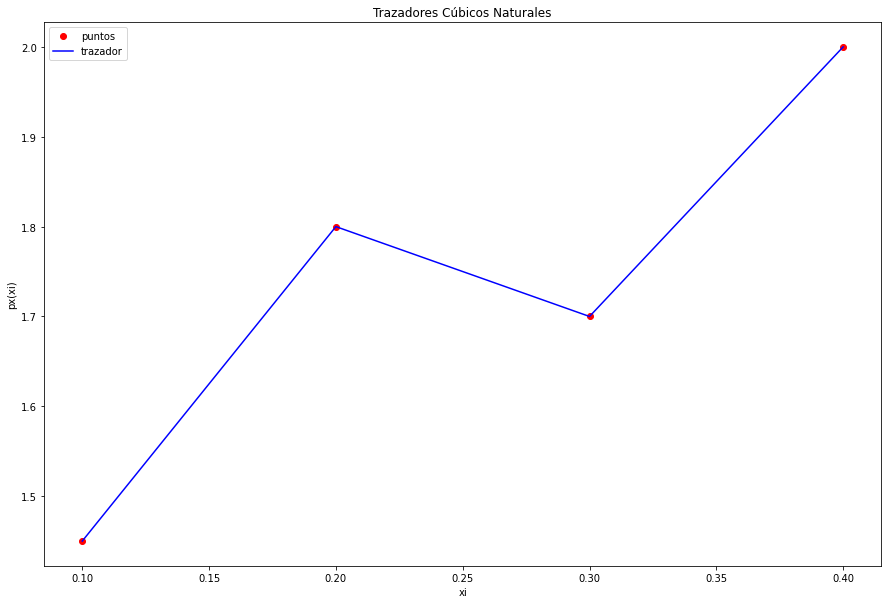

In [6]:
xi = np.array([0.1 , 0.2, 0.3, 0.4])
fi = np.array([1.45, 1.8, 1.7, 2.0])
muestras = 10 # entre cada par de puntos

ejecutar_traza3natural(xi, fi, muestras)

Polinomios por tramos: 
 x = [1,3]
-25.6124281609195*x**3 + 76.8372844827586*x**2 + 780.61242816092*x - 31.8372844827586
 x = [3,5]
36.8121408045977*x**3 - 484.983836206897*x**2 + 2466.07579022989*x - 1717.30064655172
 x = [5,7]
-21.6361350574713*x**3 + 391.740301724138*x**2 - 1917.54489942529*x + 5588.7338362069
 x = [7,13]
3.47880747126437*x**3 - 135.67349137931*x**2 + 1774.35165229885*x - 3025.69145114942


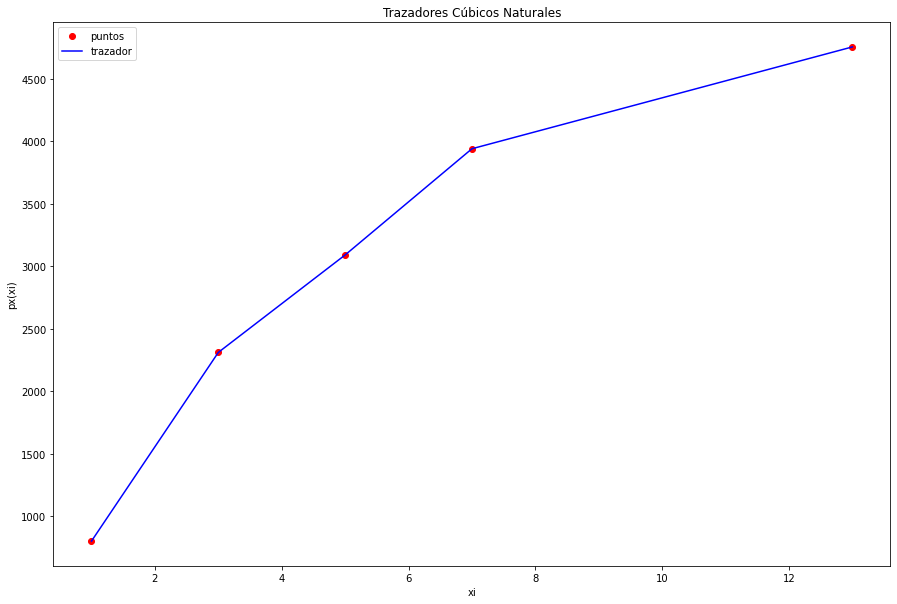

x = [1,3] ** -10154.4127155172
x = [3,5] ** 11257.214439655178
x = [5,7]** 3951.1799568965234
x = [7,13]** 4629.283405172449


In [13]:
xi = np.array([1, 3, 5, 7, 13])
fi = np.array([800, 2310, 3090, 3940, 4755])

# xi = np.array([3, 5, 7, 13])
# fi = np.array([2310, 3090, 3940, 4755])
muestras = 10 # entre cada par de puntos

ejecutar_traza3natural(xi, fi, muestras)

x= 10
result = -25.6124281609195*x**3 + 76.8372844827586*x**2 + 780.61242816092*x - 31.8372844827586
print('x = [1,3] **', result)
x= 10
result = 36.8121408045977*x**3 - 484.983836206897*x**2 + 2466.07579022989*x - 1717.30064655172
print('x = [3,5] **', result)
x= 10
result = -21.6361350574713*x**3 + 391.740301724138*x**2 - 1917.54489942529*x + 5588.733836206919
print('x = [5,7]**', result)
x= 10
result = 3.47880747126437*x**3 - 135.67349137931*x**2 + 1774.35165229885*x - 3025.69145114942
print('x = [7,13]**', result)

